# 1 Imports

In [175]:
import numpy as np
import pandas as pd
import warnings

from boruta import BorutaPy

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import inflection
from IPython.display import HTML

In [176]:
def jupyter_settings():

    sns.set(font_scale=1.6)

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)


jupyter_settings()

In [177]:
warnings.filterwarnings('ignore')
seed = 42
np.random.seed(seed)

# 2. Data Exploration

In [178]:
data = pd.read_csv('../data/fraud_trans.csv')

In [179]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [180]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,636262.000000,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,636262.000000,636262.000000
mean,242.931935,1.800585e+05,8.317937e+05,8.528354e+05,1.096212e+06,1.221809e+06,0.001290,0.000003
std,142.330857,6.069714e+05,2.885636e+06,2.921296e+06,3.375389e+06,3.656213e+06,0.035898,0.001773
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,155.000000,1.340742e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,238.000000,7.481577e+04,1.423900e+04,0.000000e+00,1.315397e+05,2.147127e+05,0.000000,0.000000
75%,334.000000,2.084988e+05,1.072998e+05,1.435652e+05,9.384820e+05,1.109230e+06,0.000000,0.000000
max,742.000000,5.722962e+07,4.368662e+07,4.367380e+07,3.551855e+08,3.555534e+08,1.000000,1.000000


## 2.1. Column Description

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction

**newbalanceDest:** new balance recipient after the transaction

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [181]:
new_cols = [inflection.underscore(col) for col in data.columns.tolist()]
data.columns = new_cols
data.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [182]:
print(f'Data shape {data.shape}')

Data shape (636262, 11)


In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


In [184]:
data.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

In [185]:
# change data type

data['is_fraud'] = data['is_fraud'].map({1: 'yes', 0: 'no'})
data['is_flagged_fraud'] = data['is_flagged_fraud'].map({1: 'yes', 0: 'no'})
data.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,no,no
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,no,no
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,no,no
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,no,no
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,no,no


Text(0.5, 1.0, 'Balance Change (Original Accounts)')

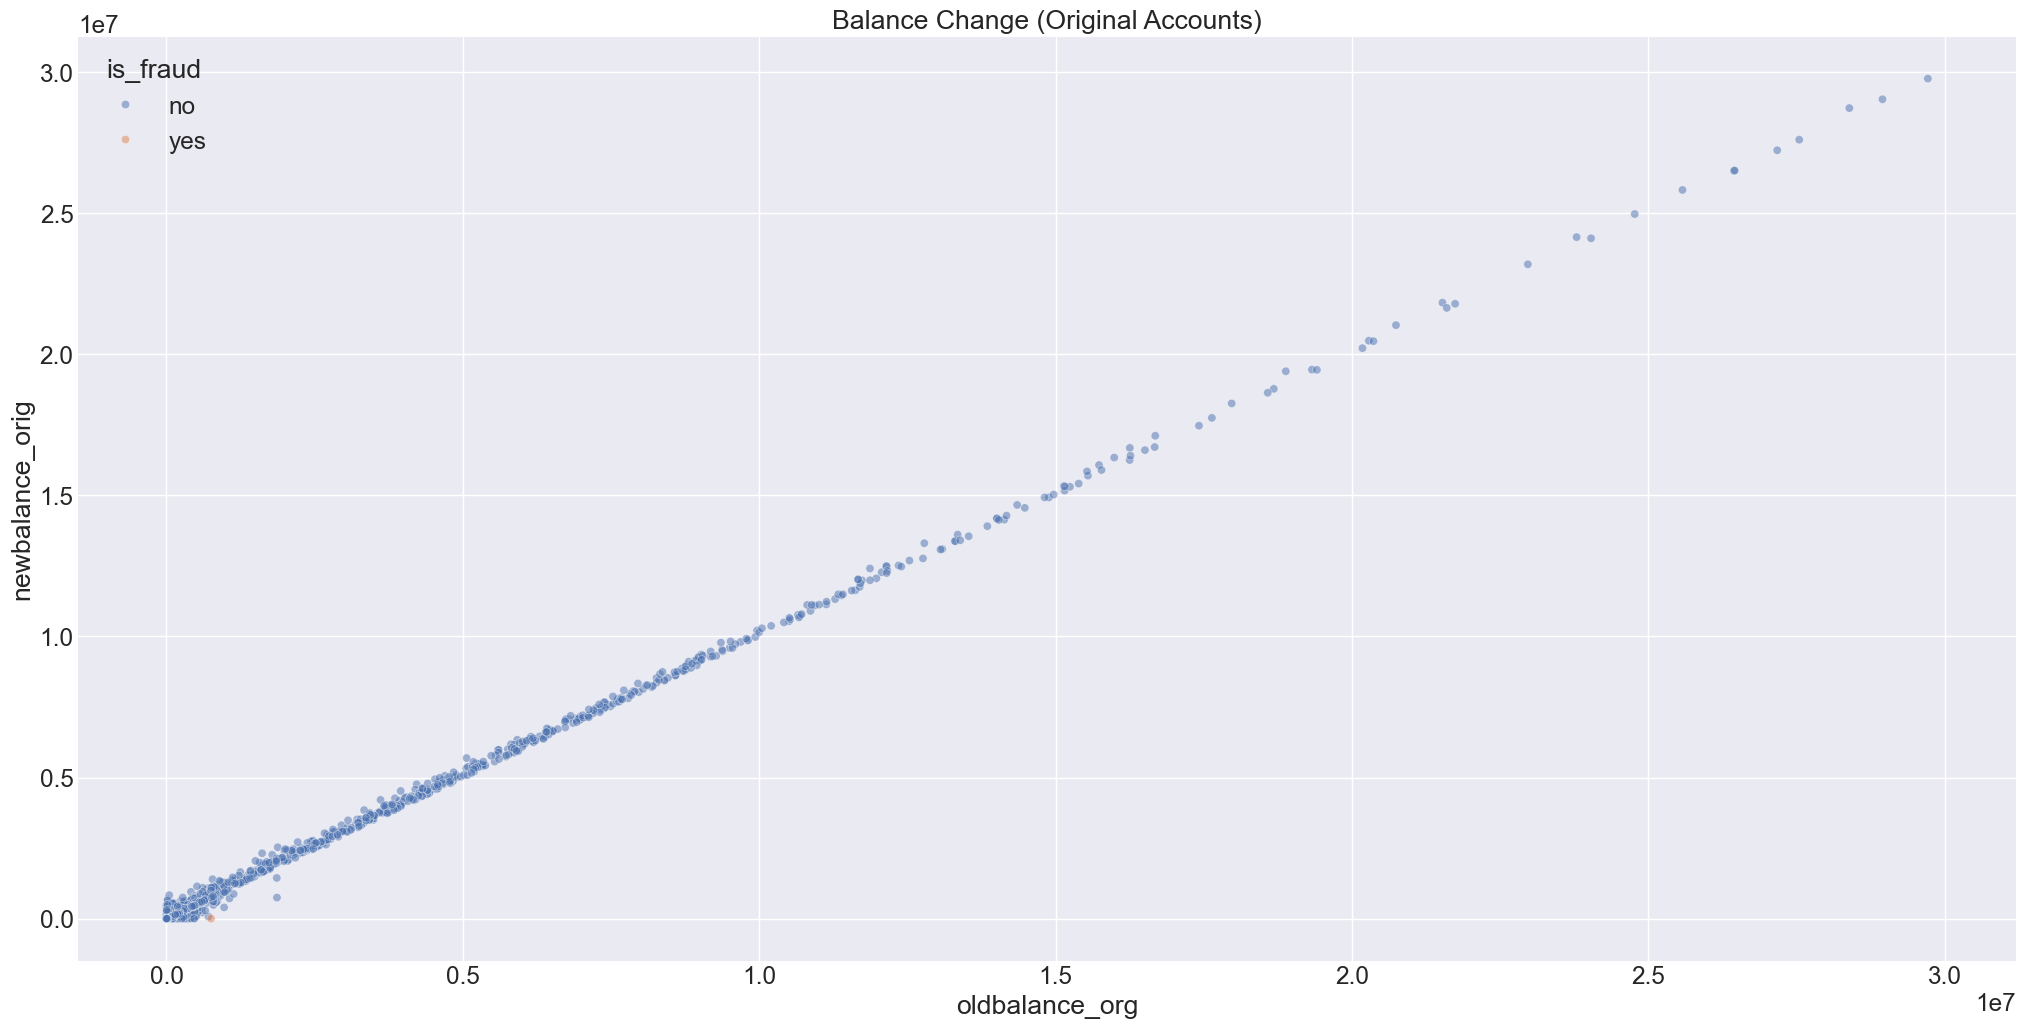

In [186]:
sns.scatterplot(
    data=data.sample(5000),
    x='oldbalance_org',
    y='newbalance_orig',
    hue='is_fraud',
    alpha=0.5
)
plt.title('Balance Change (Original Accounts)')

Text(0.5, 1.0, 'Transaction Type Distribution')

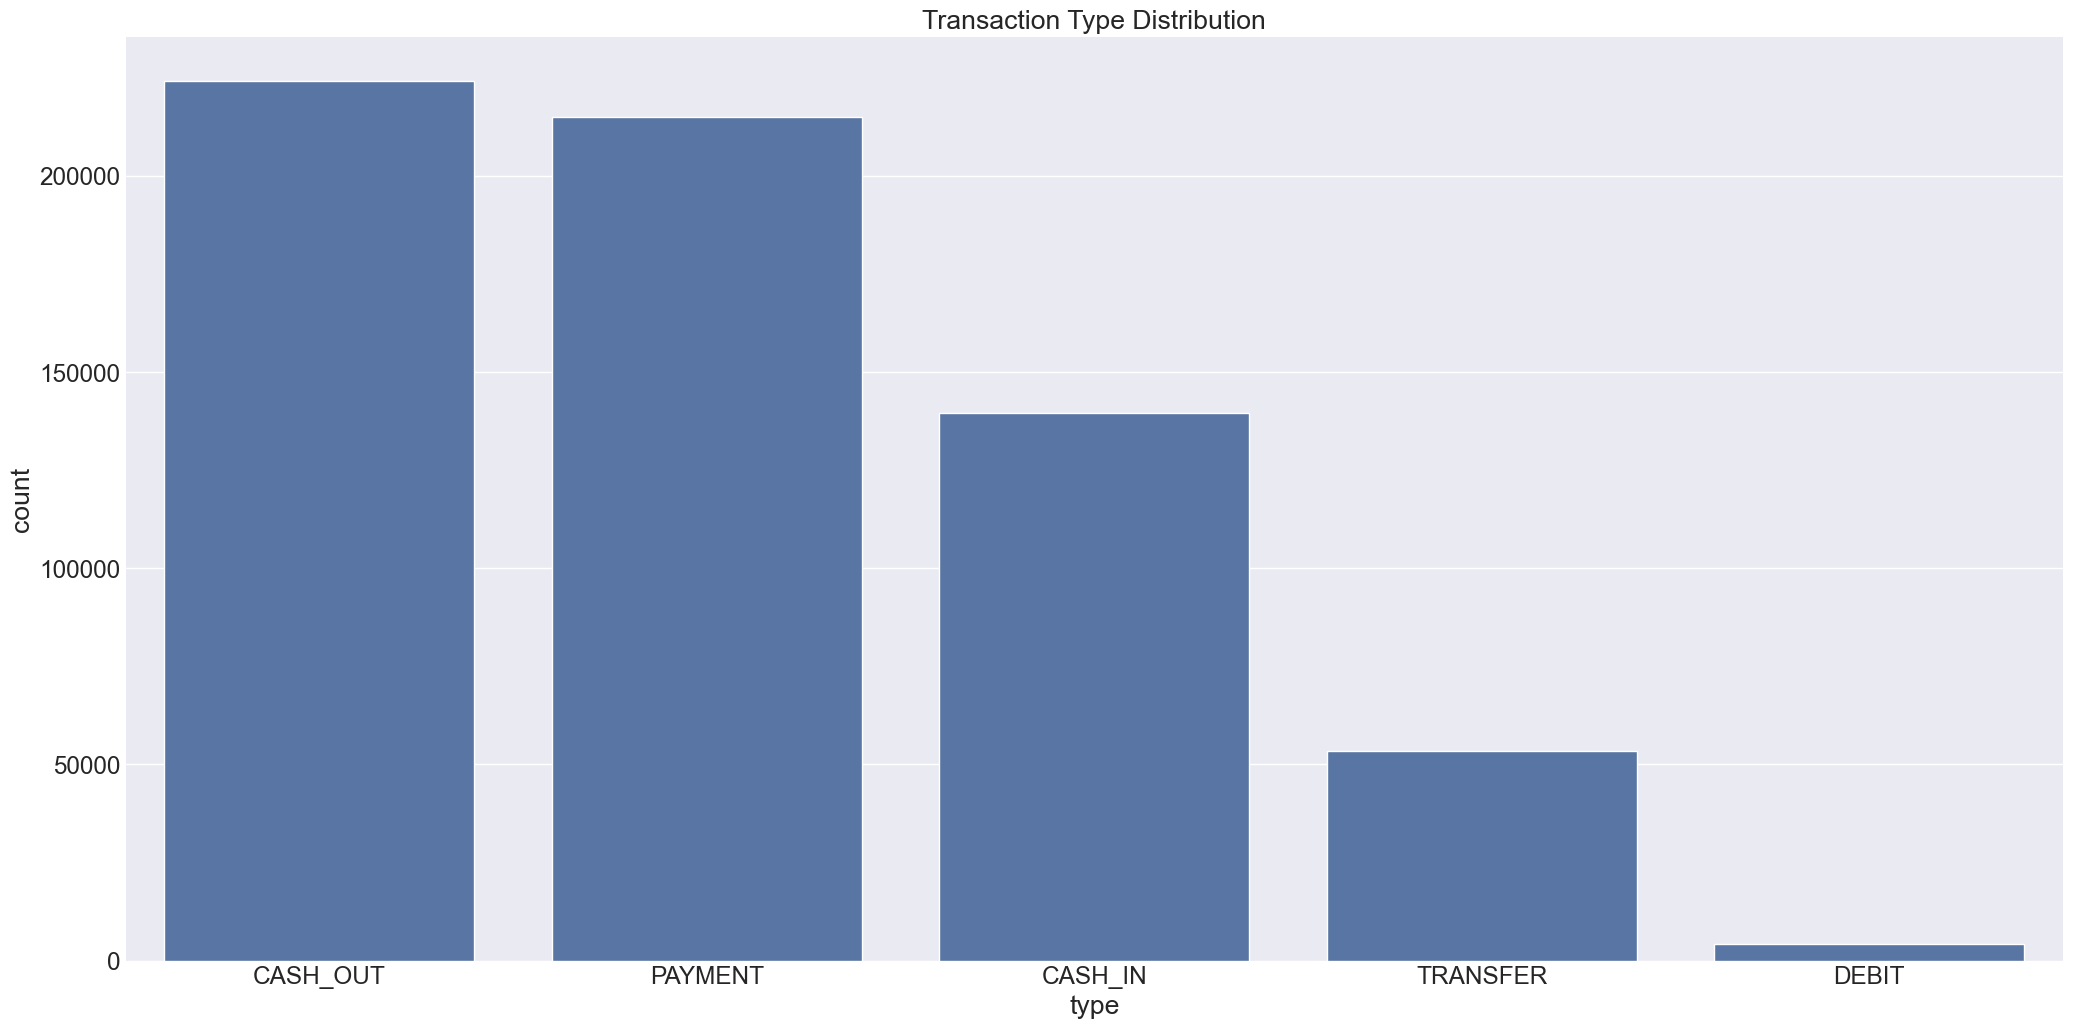

In [187]:
sns.countplot(data=data, x='type', order=data['type'].value_counts().index)
plt.title('Transaction Type Distribution')

Text(0.5, 1.0, 'Fraudulent Ratio')

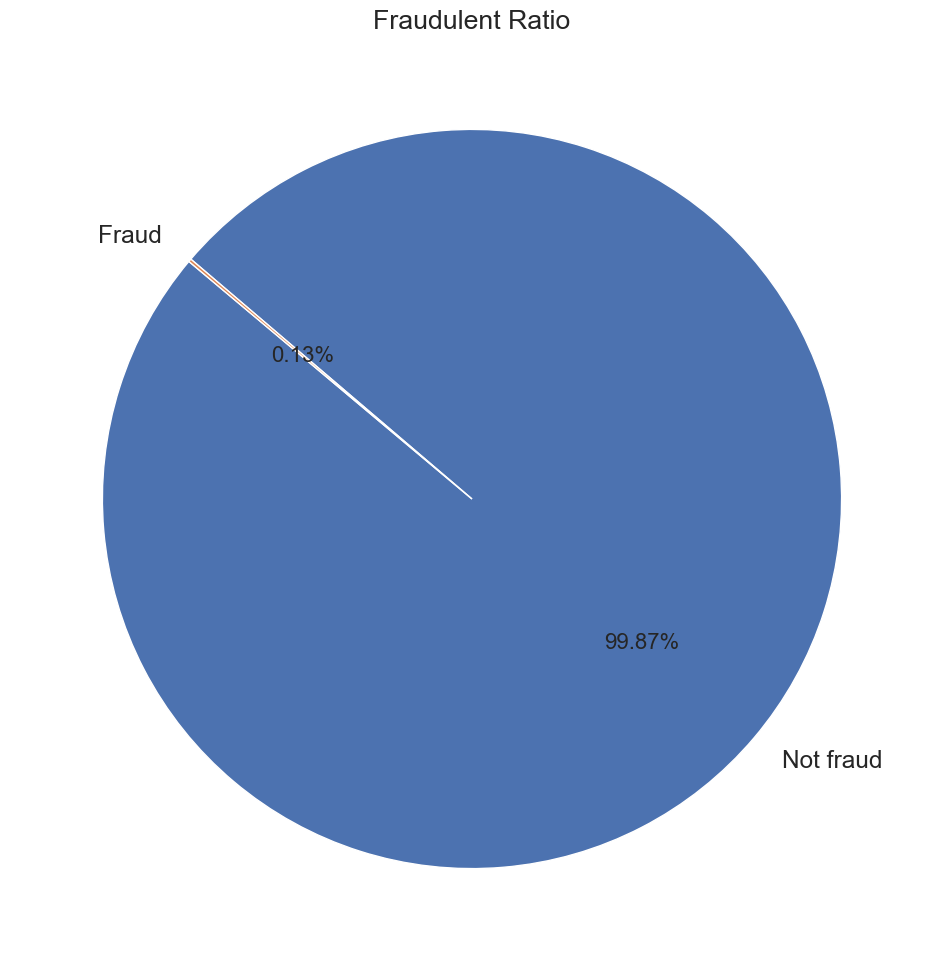

In [188]:
labels = ['Not fraud', 'Fraud']
fraud_counts = data['is_fraud'].value_counts()
plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', startangle=140)
plt.title('Fraudulent Ratio')

In [189]:
num_attributes = data.select_dtypes(exclude='object')
cat_attributes = data.select_dtypes(include='object')

In [190]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['coefficient of Variation'] = (
    num_attributes.std() / num_attributes.mean())
describe['skewness'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,coefficient of Variation,skewness,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


In [191]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C1785652992,C1023714065,no,no
freq,224216,2,14,635441,636260


# 3. Feature Engineering

In [192]:
df = data.copy()

In [193]:
df['step_days'] = [step / 24 for step in df['step']]
df['step_weeks'] = [step / 168 for step in df['step']]

df['diff_new_old_orig'] = df['newbalance_orig'] - df['oldbalance_org']

df['diff_new_old_dest'] = df['newbalance_dest'] - df['oldbalance_dest']

df['name_orig'] = [name[0] for name in df['name_orig']]
df['name_dest'] = [name[0] for name in df['name_dest']]

df.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_orig,diff_new_old_dest
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,no,no,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,no,no,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,no,no,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,no,no,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,no,no,15.875000,2.267857,0.00,8858.45


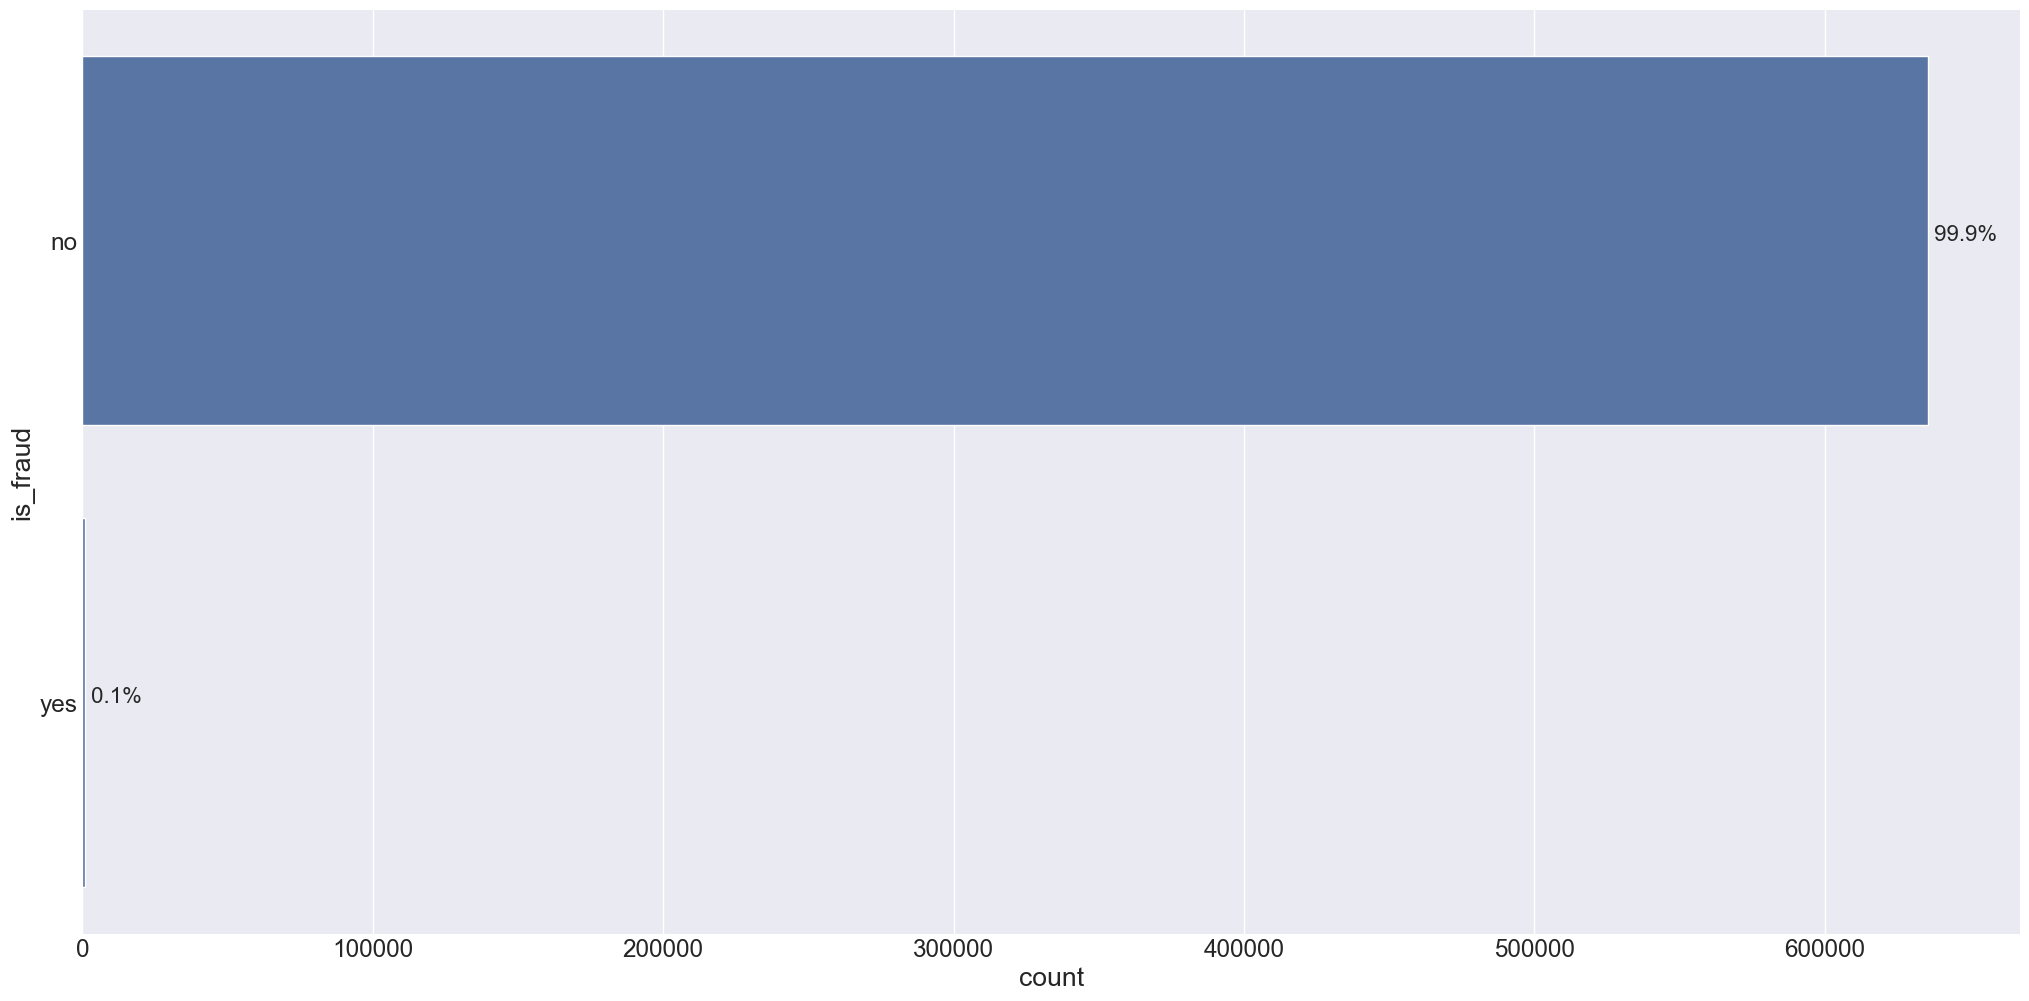

In [194]:
ax = sns.countplot(y='is_fraud', data=df)

total = df['is_fraud'].size
for p in ax.patches:
    percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

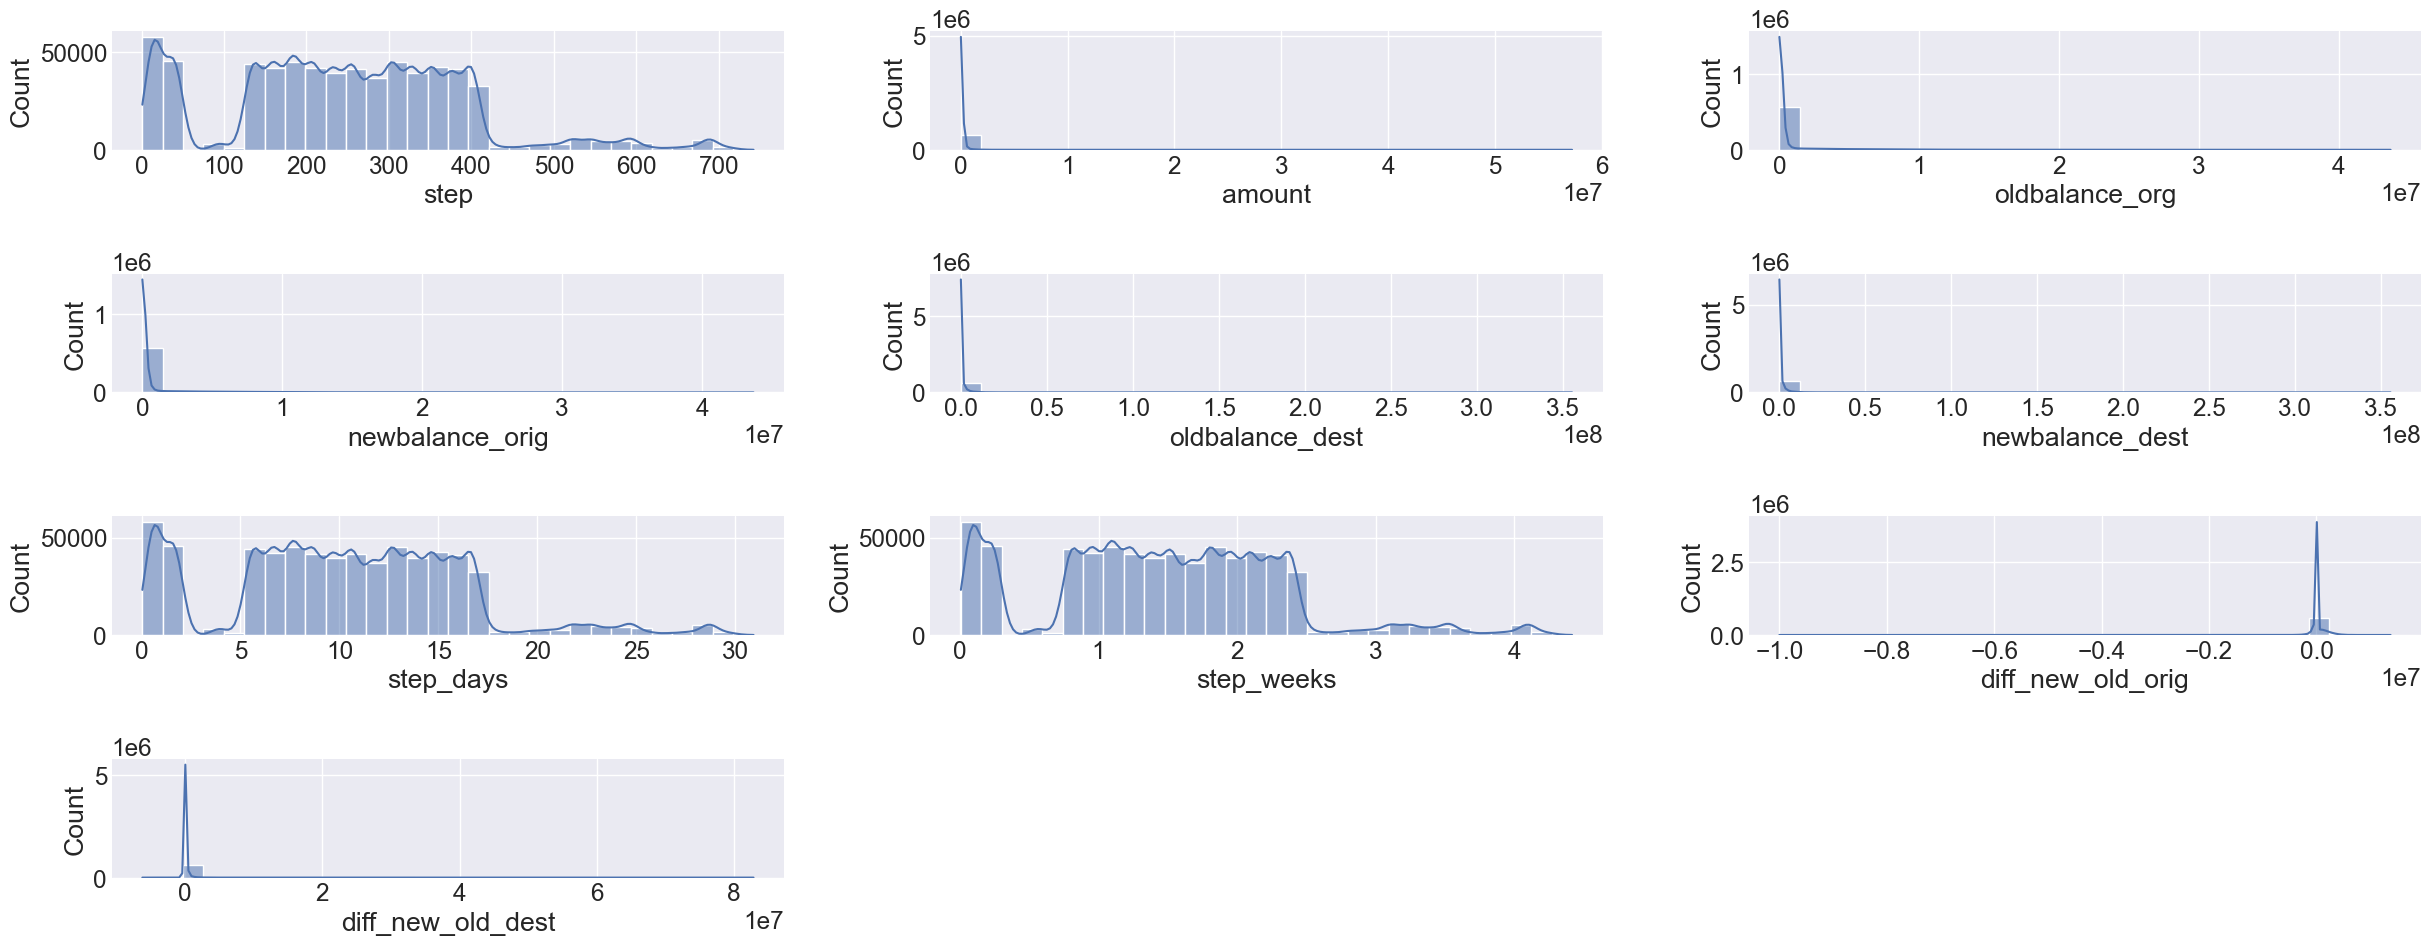

In [195]:
num_attributes = df.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(5, 3, j)
    sns.histplot(num_attributes[column], bins=30, kde=True)

    j += 1

plt.tight_layout(pad=2.0)

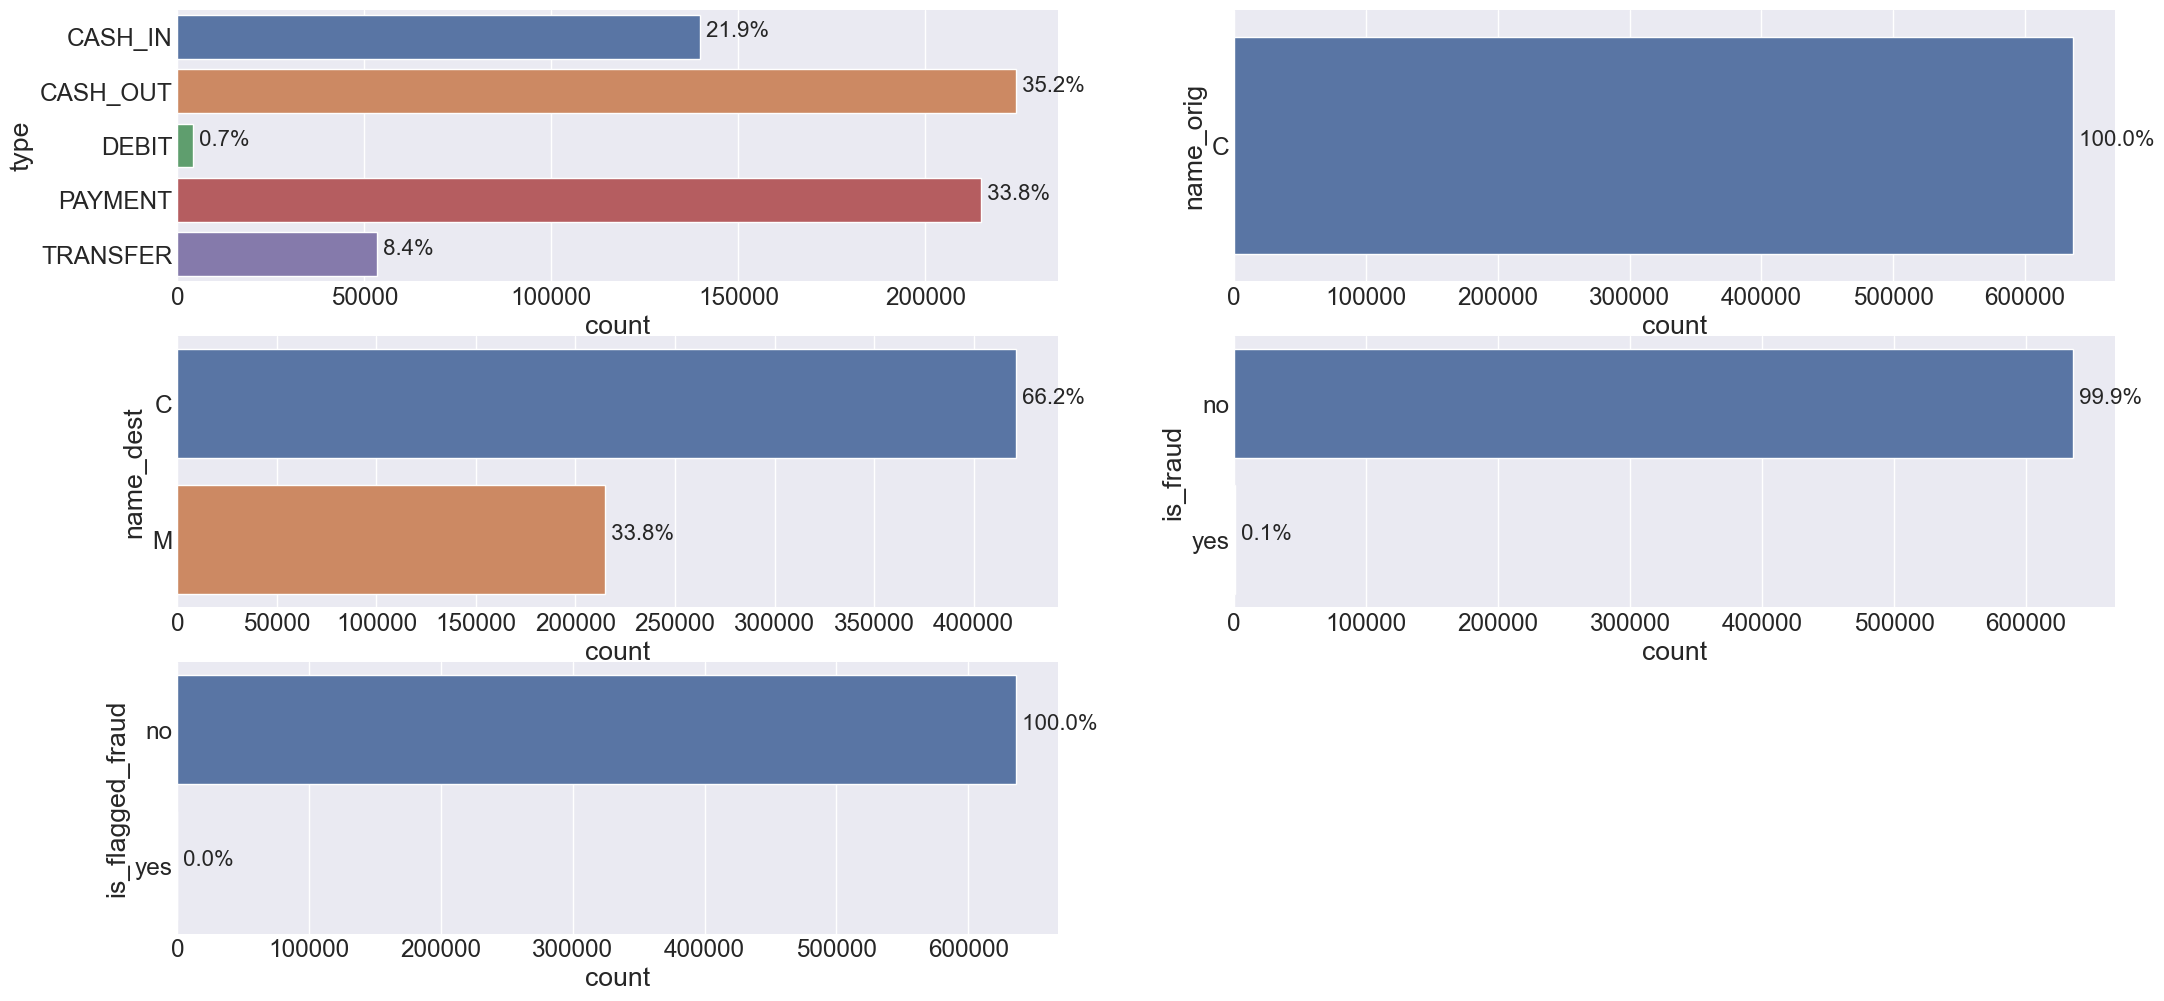

In [196]:
cat_attributes = df.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes, hue=column)

    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    j += 1

In [197]:
dat = df[df['is_fraud'] == 'yes']

<Axes: xlabel='count', ylabel='name_orig'>

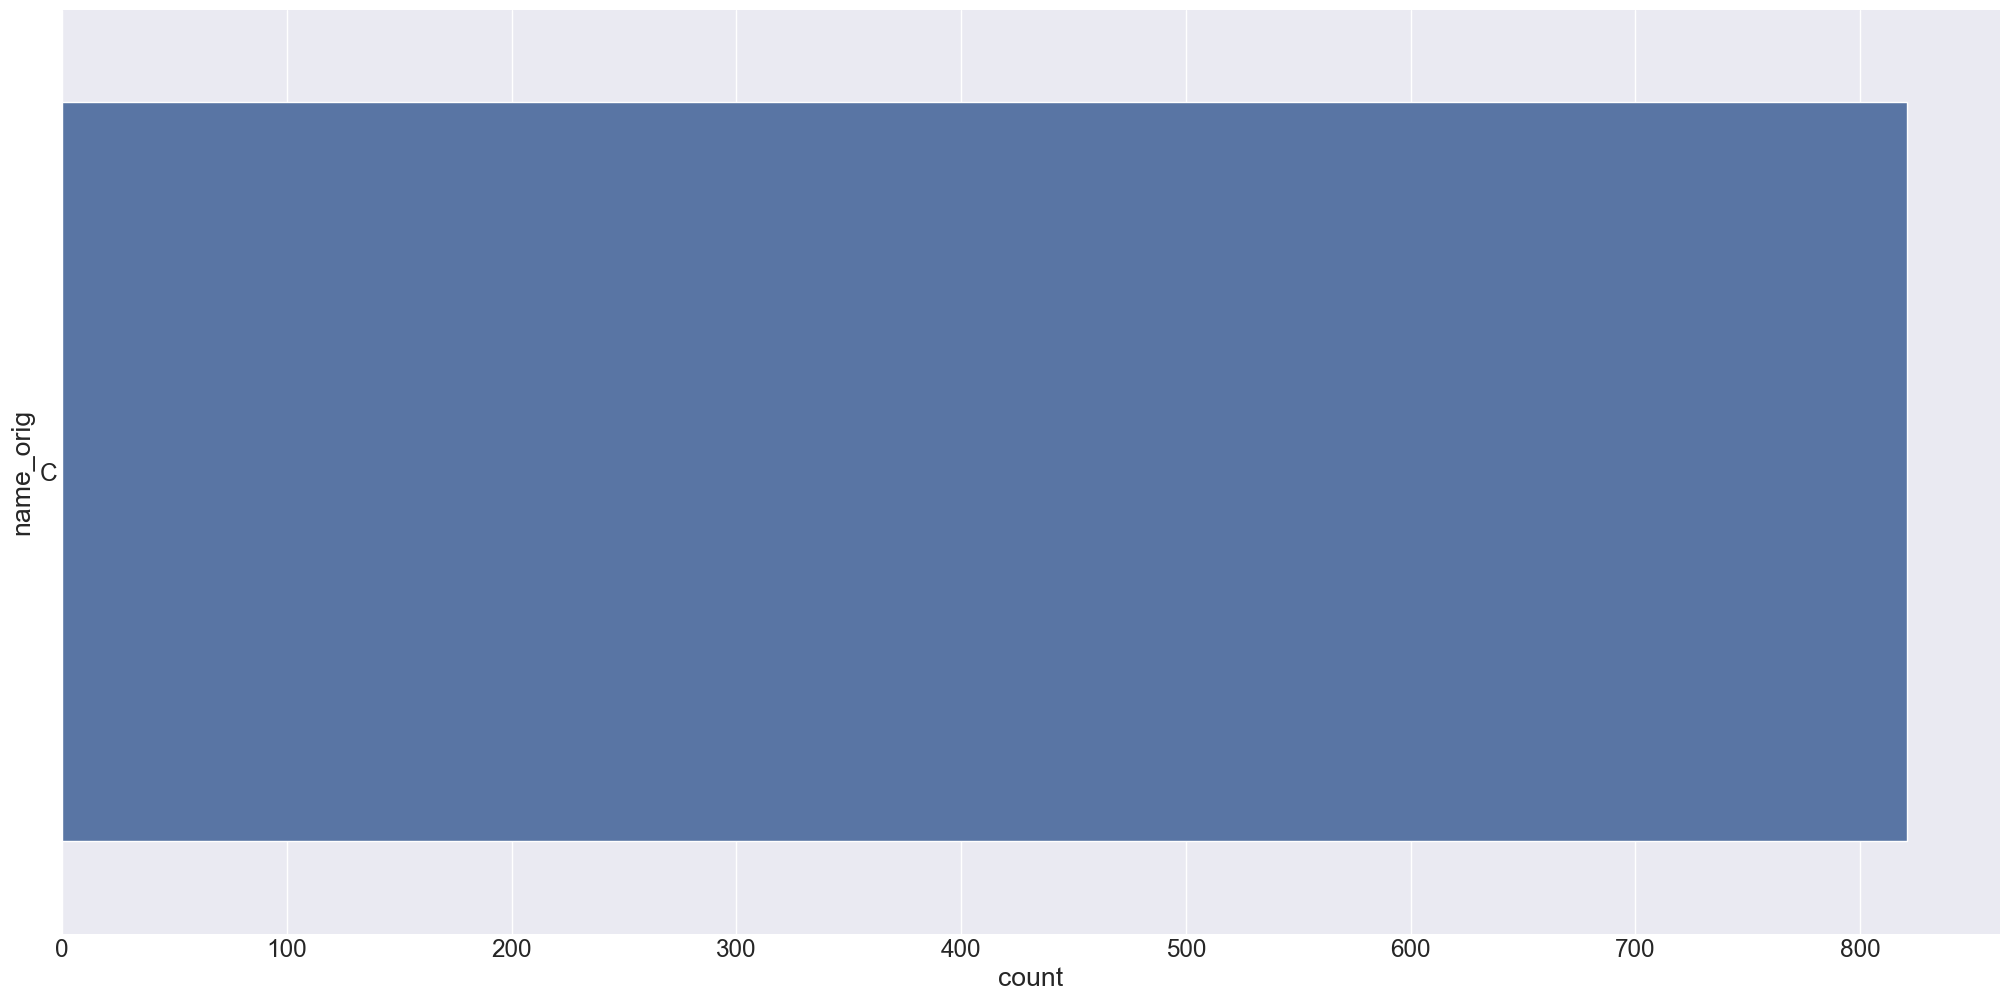

In [198]:
# ratio is fraud by name
sns.countplot(y='name_orig', data=dat)

<Axes: xlabel='count', ylabel='name_dest'>

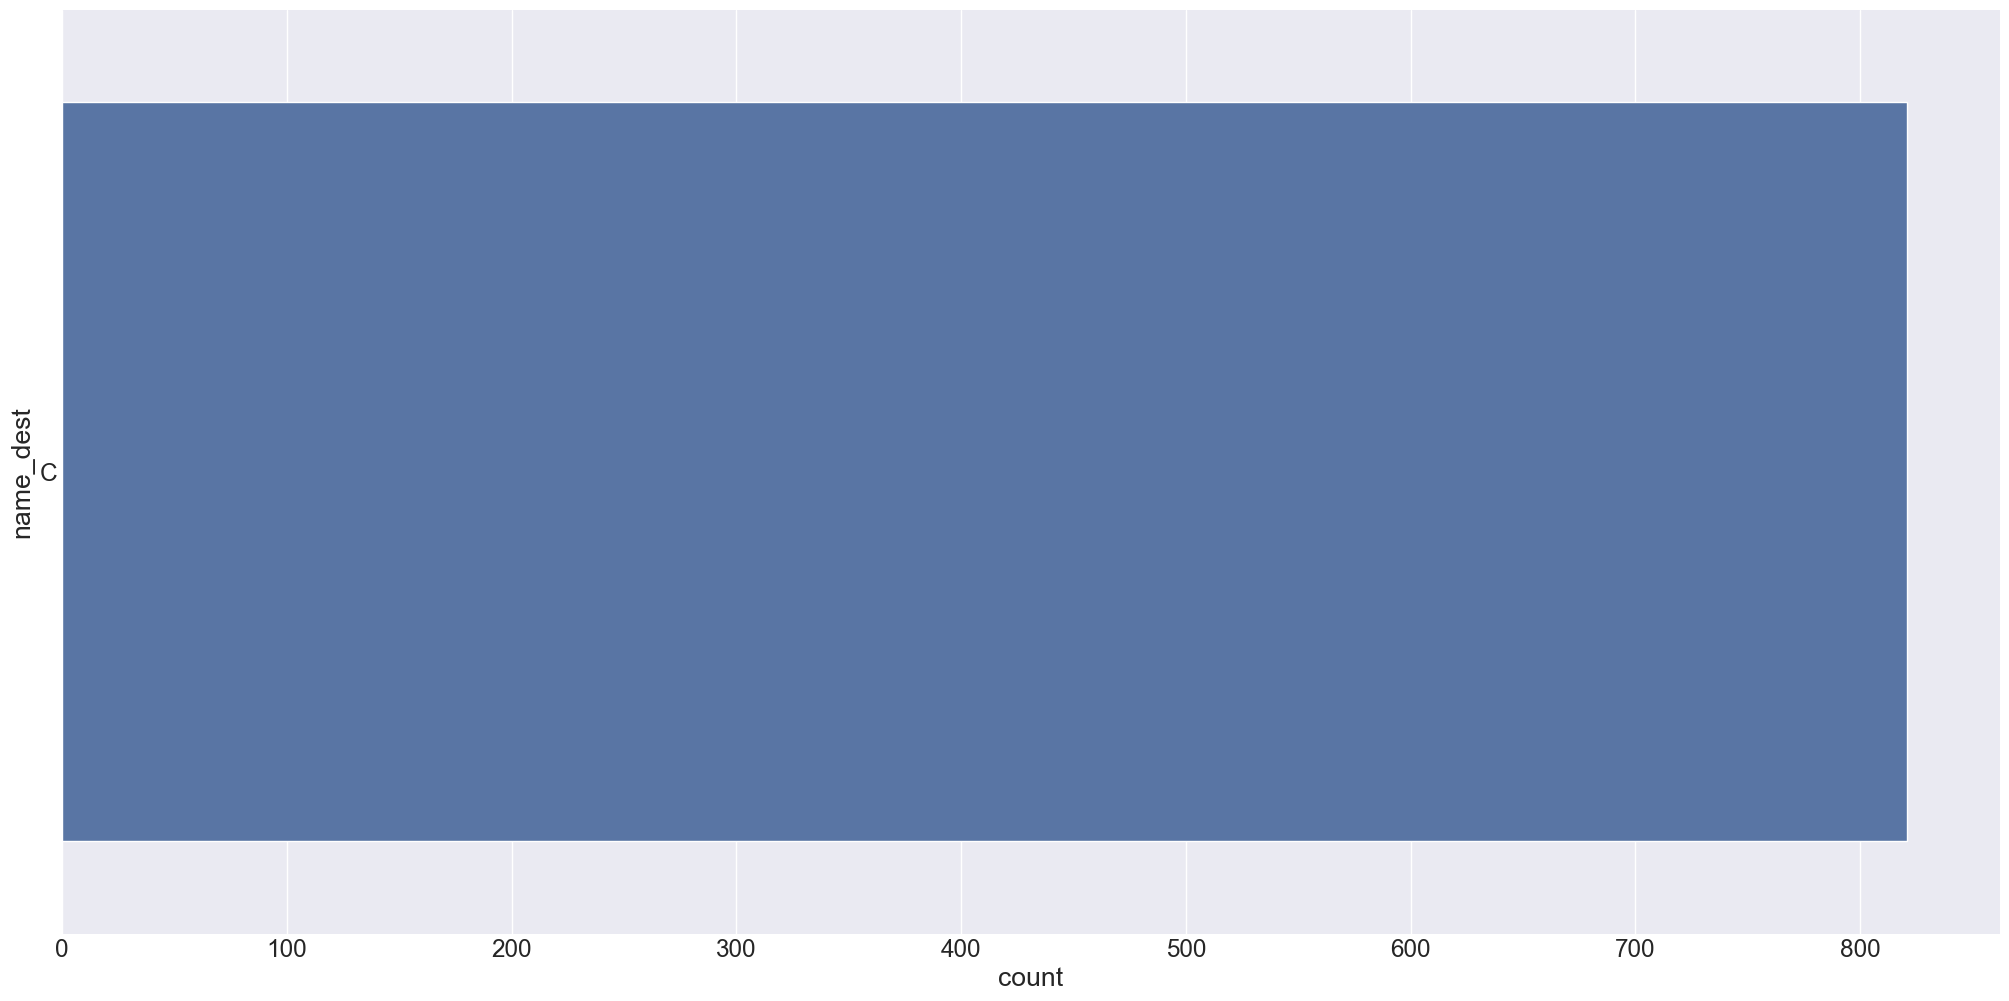

In [199]:
sns.countplot(y='name_dest', data=dat)

The same user orig and dest have got the same inital letter

<Axes: xlabel='is_fraud', ylabel='amount'>

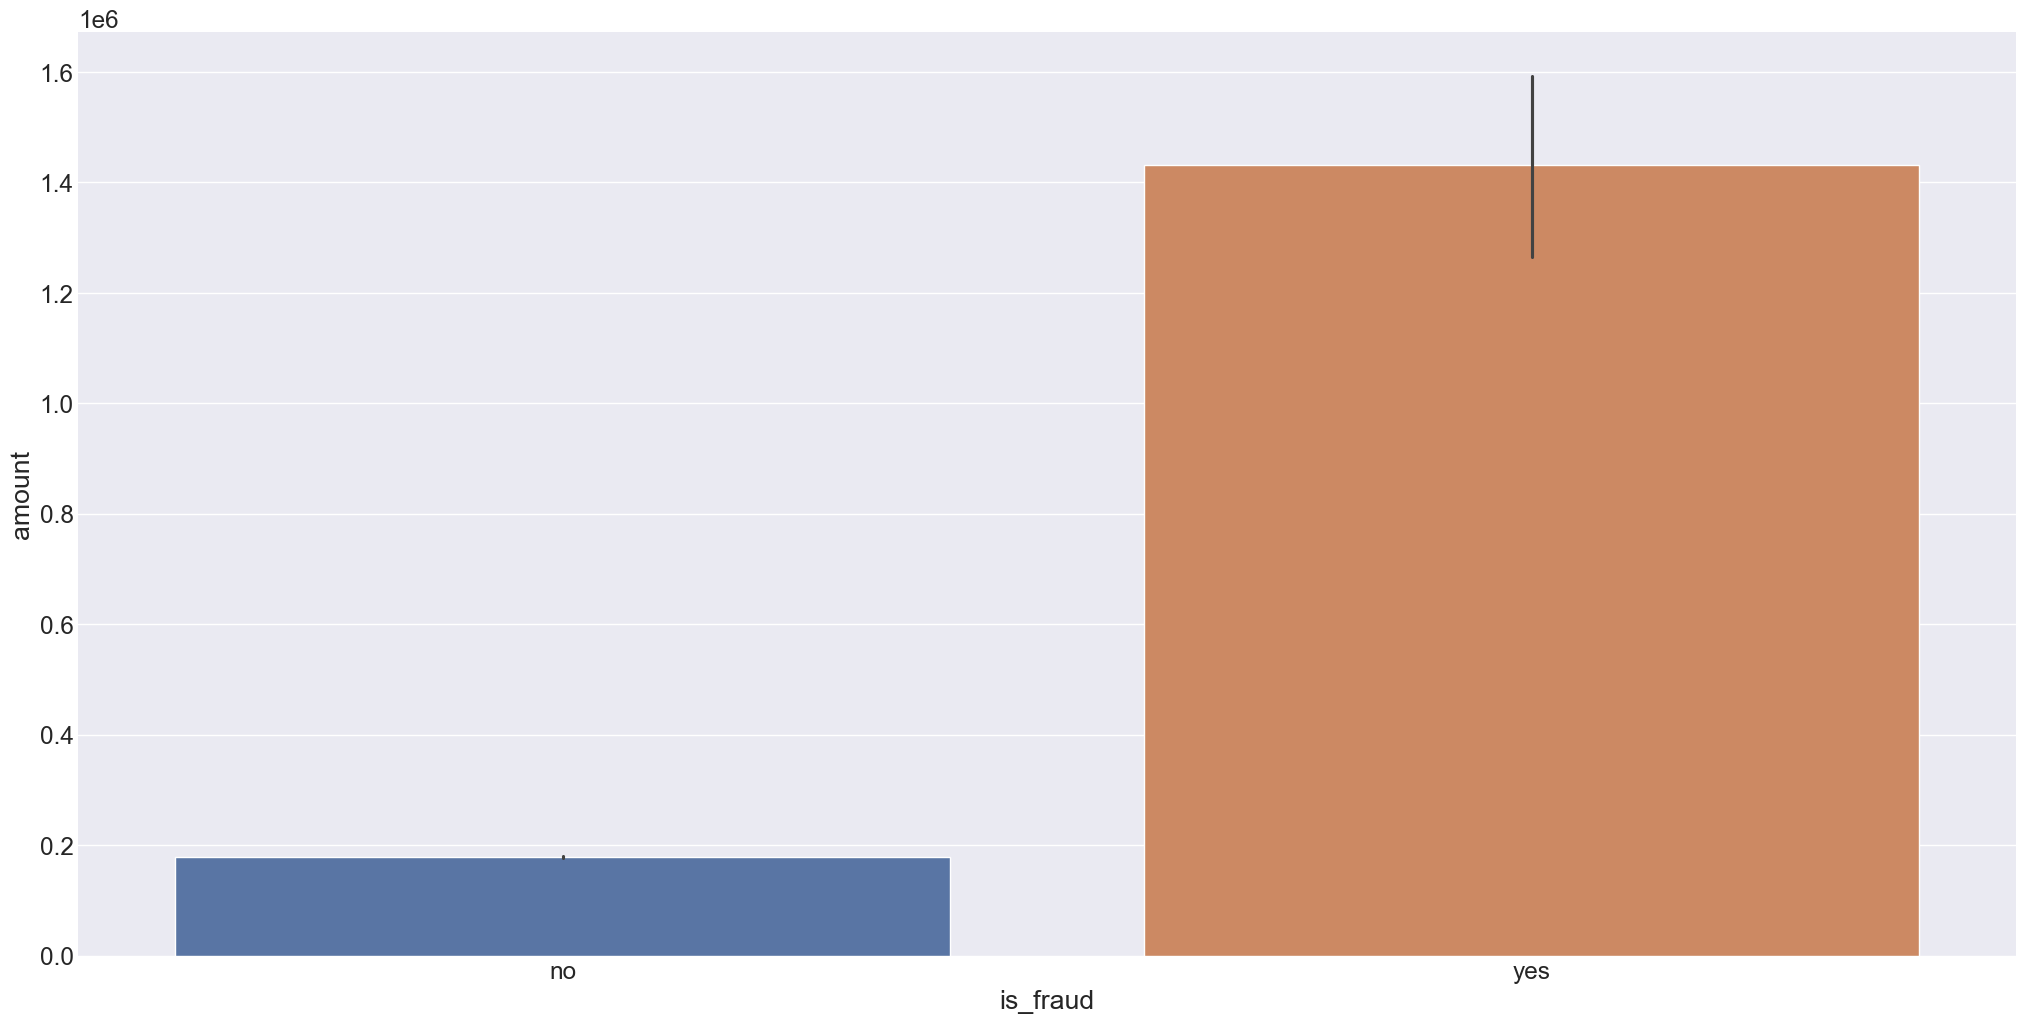

In [200]:
sns.barplot(y='amount', x='is_fraud', data=df, hue='is_fraud')

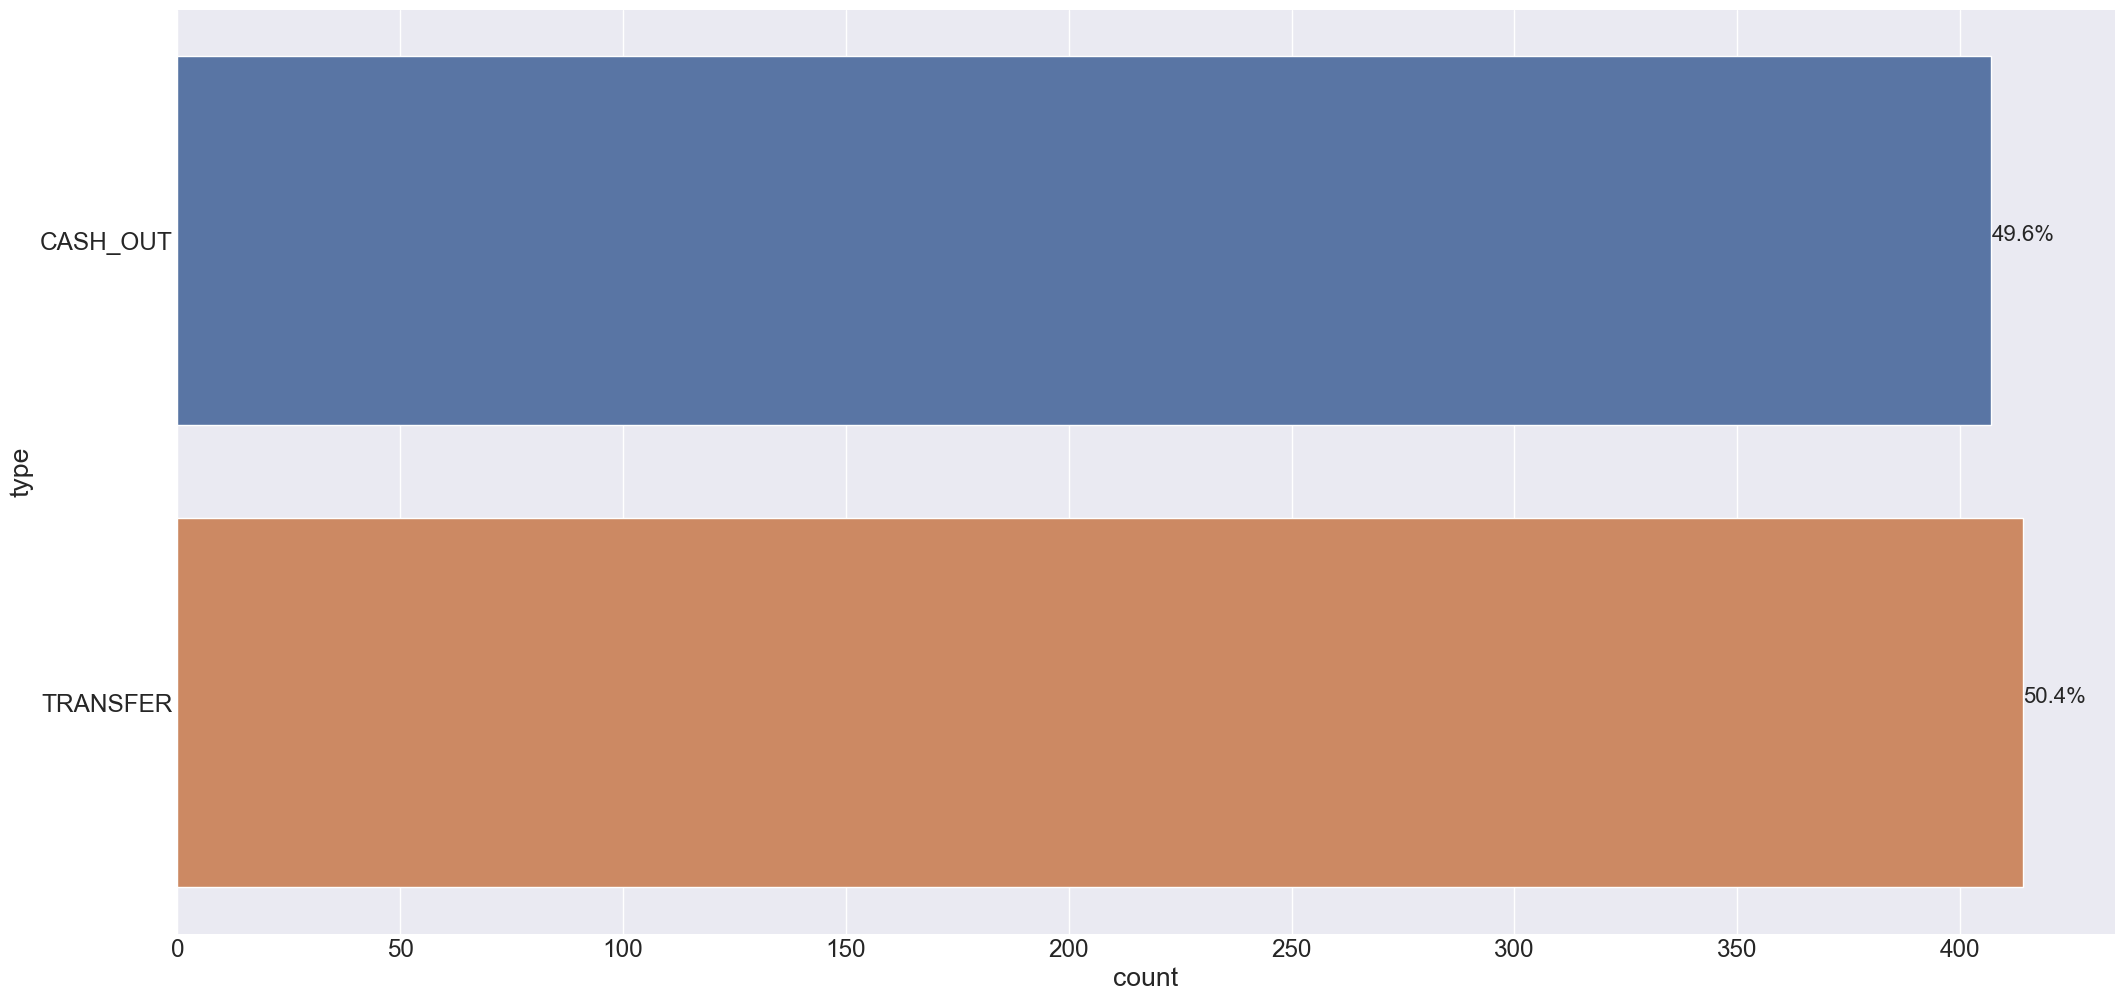

In [201]:
ax = sns.countplot(y='type', data=dat, hue='type')

total = dat['type'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

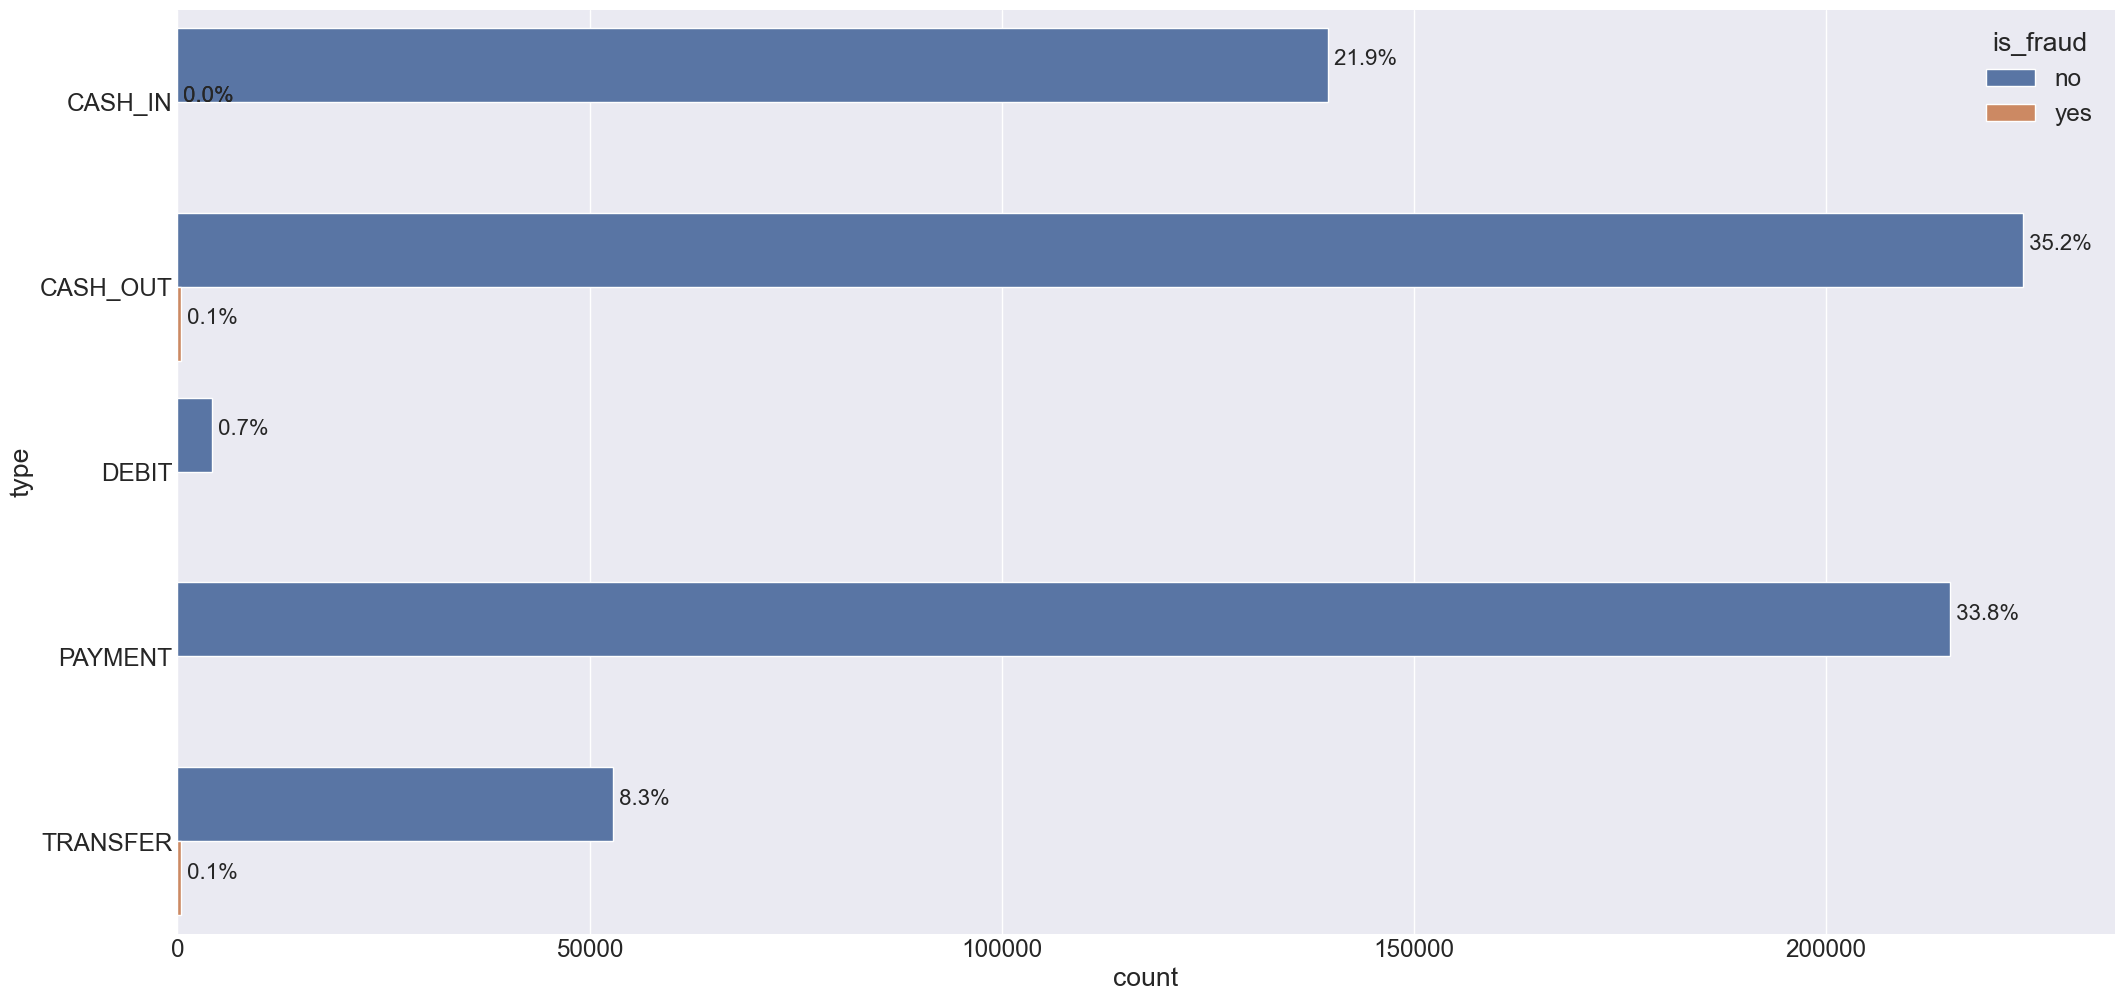

In [202]:
ax = sns.countplot(y='type', hue='is_fraud', data=df)

total = df['type'].size
for p in ax.patches:
    percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

<Axes: xlabel='step_days', ylabel='amount'>

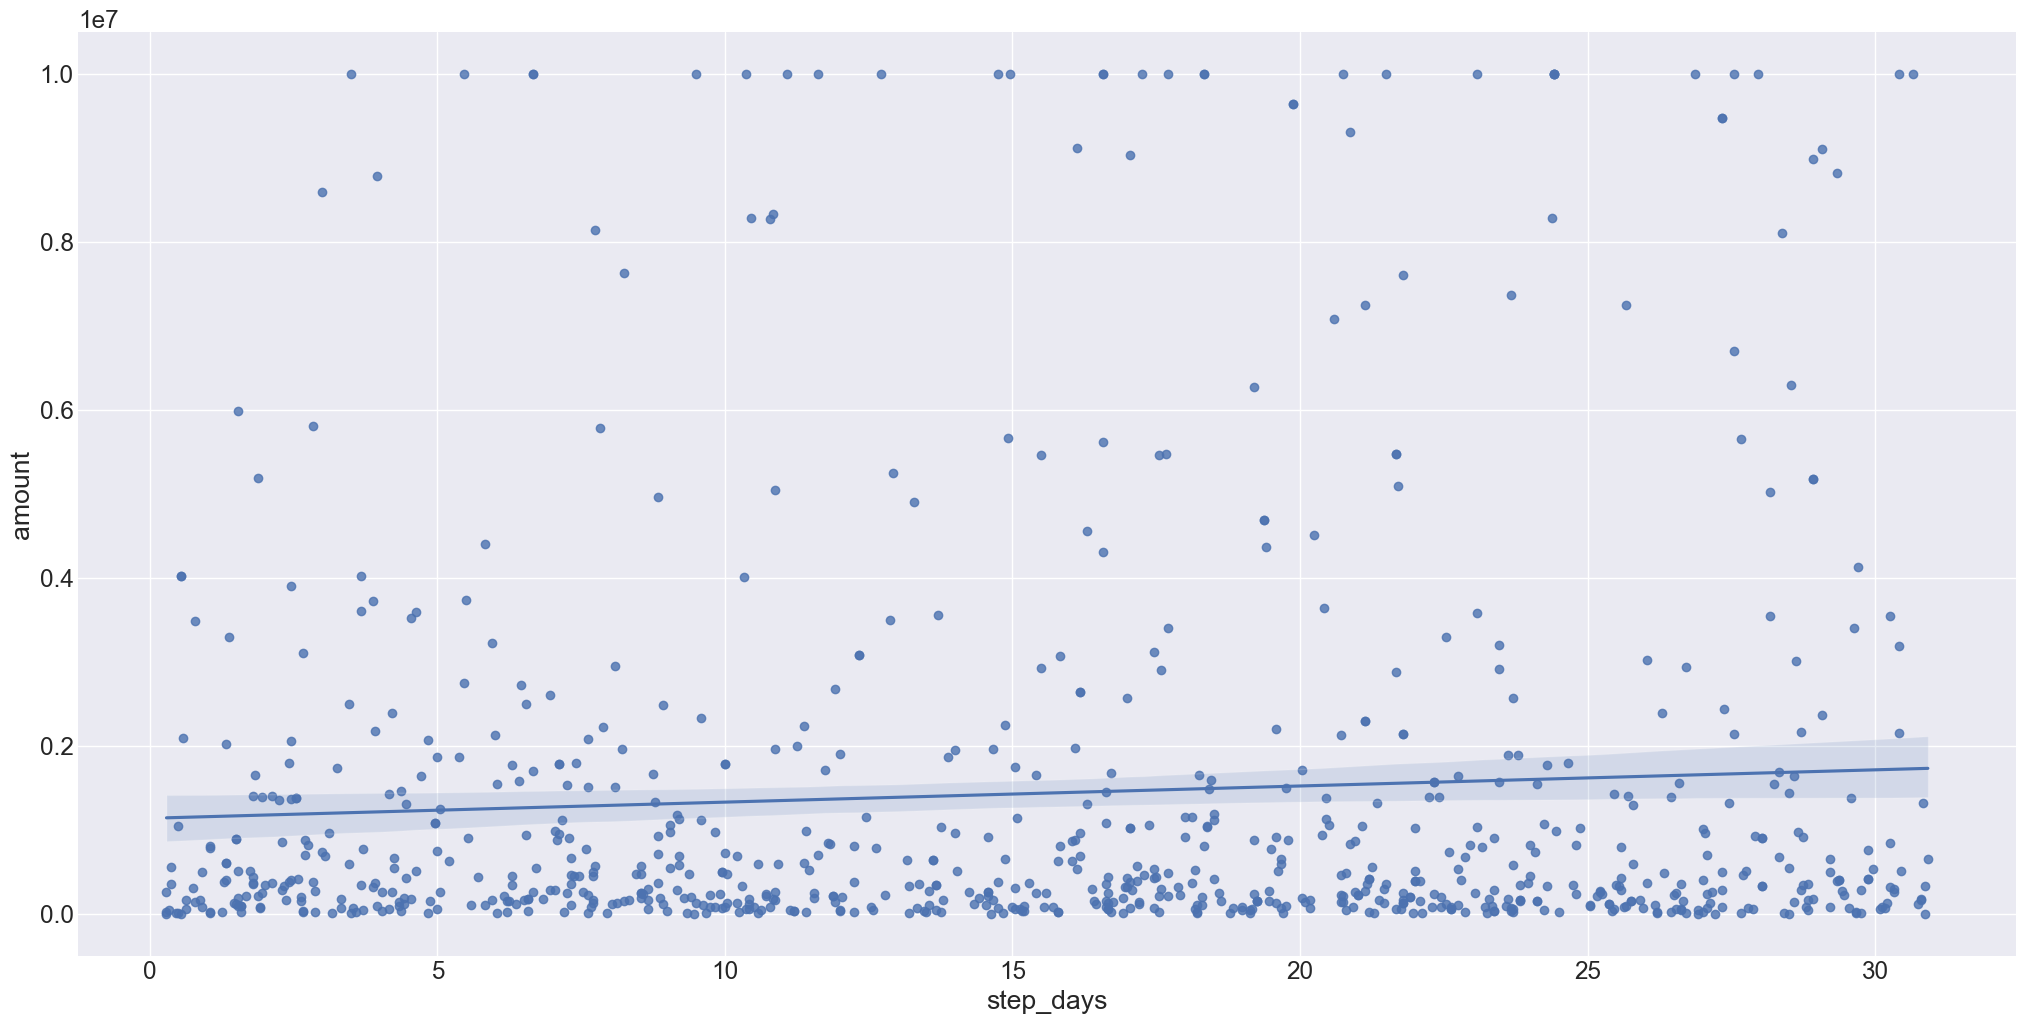

In [203]:
sns.regplot(x='step_days', y='amount', data=dat)

# 4. Multivariaty Analysis

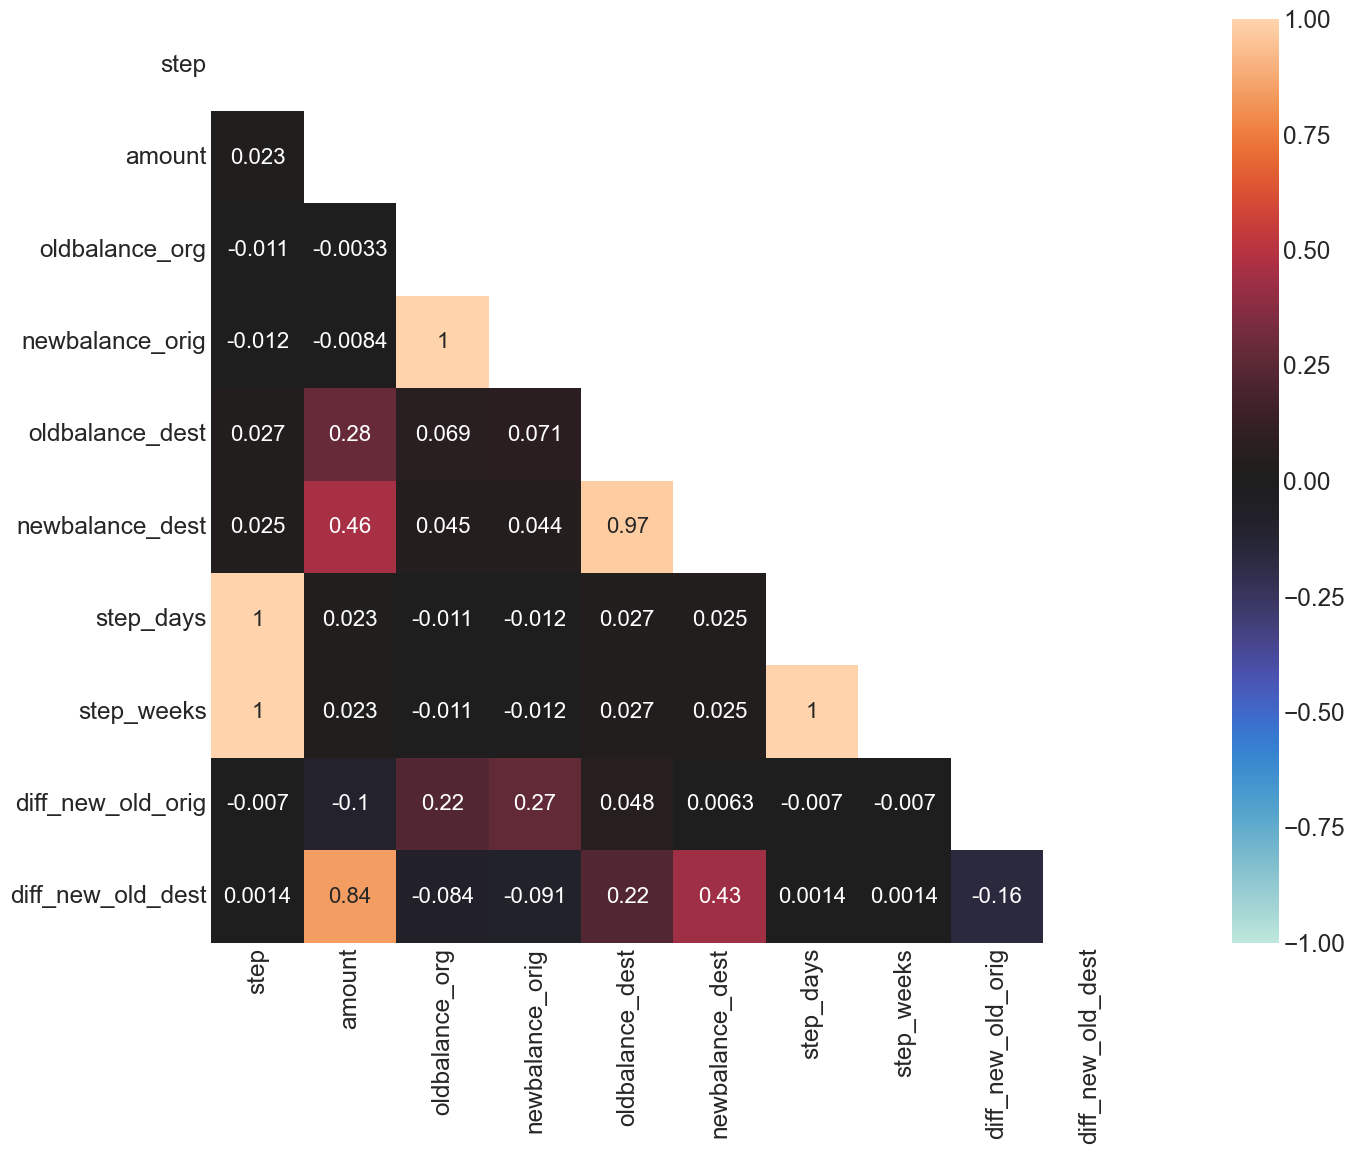

In [204]:
# numerical analysis

corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-
                     1, center=0, vmax=1, square=True)

# 5. Data Preparation

In [205]:
df2 = df.copy()
X = df2.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)
y = df2['is_fraud'].map({'yes': 1, 'no': 0})

In [206]:
# split test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=.2, stratify=y)

# split train and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=.2, stratify=y_temp)

In [207]:
# one hot encode
oh = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = oh.fit_transform(X_train)
X_valid = oh.transform(X_valid)

X_temp = oh.fit_transform(X_temp)
X_test = oh.transform(X_test)

In [208]:
# scaling

X.select_dtypes(exclude='object').columns
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig',
               'oldbalance_dest', 'newbalance_dest', 'diff_new_old_orig',
               'diff_new_old_dest']

scaler = MinMaxScaler()
# scaler = RobustScaler()
X_params = X_temp.copy()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_valid[num_columns] = scaler.transform(X_valid[num_columns])

X_params[num_columns] = scaler.fit_transform(X_params[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

# 6. Feature Selection

In [209]:
X_boruta = X_params.values
y_boruta = y_temp.values.ravel()

In [210]:
# boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
# boruta.fit(X_boruta, y_boruta)

# too slow

In [211]:
# cols_selected_boruta = boruta.support_.tolist( )
# columns_selected = X_params.loc[:,cols_selected_boruta].columns.tolist()
# columns_selected


# ['step',
#  'type_TRANSFER',
#  'amount',
#  'oldbalance_org',
#  'newbalance_orig',
#  'oldbalance_dest',
#  'newbalance_dest',
#  'diff_new_old_orig',
#  'diff_new_old_dest']

In [212]:
columns_selected = ['step',
                    'type_TRANSFER',
                    'oldbalance_org',
                    'newbalance_orig',
                    'newbalance_dest',
                    'diff_new_old_orig',
                    'diff_new_old_dest']

# 7. Modeling

In [213]:
def ml_scores(model_name, y_true, y_pred):
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         },
                        index=[model_name])

In [214]:
def ml_cross_validation(model_name, model, x, y, verbose=True):
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []

    scaler = MinMaxScaler()
    # scaler = RobustScaler()

    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for index_train, index_test in skf.split(x_, y_):
        if verbose:
            count += 1
            print(f'Fold K={count}')

        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))

    '''results'''
    accuracy_mean, accuracy_std = np.round(
        np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(
        np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(
        np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)

    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                         "Recall": "{} +/- {}".format(recall_mean, recall_std),
                         "F1": "{} +/- {}".format(f1_mean, f1_std)},
                        index=[model_name])

In [215]:
X_train_cs = X_train[columns_selected]
X_valid_cs = X_valid[columns_selected]

X_temp_cs = X_temp[columns_selected]
X_test_cs = X_test[columns_selected]

X_params_cs = X_params[columns_selected]

## 7.1. Baseline

In [216]:
# Baseline
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [217]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1
dummy,0.5,0.0,0.0,0.0


In [218]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



In [219]:
# cross validation
dummy_cv = ml_cross_validation('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2. Logistic Regression

In [267]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [221]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1
Logistic Regression,0.595,1.0,0.191,0.321


In [222]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.19      0.32       131

    accuracy                           1.00    101802
   macro avg       1.00      0.60      0.66    101802
weighted avg       1.00      1.00      1.00    101802



In [223]:
lg_cv = ml_cross_validation('Logistic Regression',
                      LogisticRegression(), 
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1
Logistic Regression,0.521 +/- 0.002,1.0 +/- 0.0,0.041 +/- 0.004,0.079 +/- 0.007


## 7.3. K Nearest Neighbors

In [224]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [225]:
knn_results = ml_scores('K Nearest Neighbor', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1
K Nearest Neighbor,0.565,0.895,0.13,0.227


In [226]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.89      0.13      0.23       131

    accuracy                           1.00    101802
   macro avg       0.95      0.56      0.61    101802
weighted avg       1.00      1.00      1.00    101802



In [227]:
knn_cv = ml_cross_validation('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1
K Nearest Neighbors,0.699 +/- 0.018,0.95 +/- 0.025,0.397 +/- 0.035,0.559 +/- 0.036


## 7.4. Support Vector Machine

In [264]:
svm = SVC(probability=True)
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [229]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1
SVM,0.5,0.0,0.0,0.0


In [230]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



In [231]:
svm_cv = ml_cross_validation('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1
SVM,0.597 +/- 0.015,1.0 +/- 0.0,0.195 +/- 0.031,0.325 +/- 0.043


## 7.5. Random Forest

In [232]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [233]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1
Random Forest,0.866,0.99,0.733,0.842


In [234]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.99      0.73      0.84       131

    accuracy                           1.00    101802
   macro avg       0.99      0.87      0.92    101802
weighted avg       1.00      1.00      1.00    101802



In [235]:
rf_cv = ml_cross_validation('Random Forest', RandomForestClassifier(), X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1
Random Forest,0.874 +/- 0.012,0.974 +/- 0.011,0.747 +/- 0.024,0.846 +/- 0.016


## 7.6. XGBoost

In [236]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [237]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1
XGBoost,0.893,0.972,0.786,0.869


In [238]:
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.97      0.79      0.87       131

    accuracy                           1.00    101802
   macro avg       0.99      0.89      0.93    101802
weighted avg       1.00      1.00      1.00    101802



In [239]:
xgb_cv = ml_cross_validation('XGBoost', XGBClassifier(), X_temp_cs, y_temp)
xgb_cv


Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1
XGBoost,0.889 +/- 0.014,0.934 +/- 0.018,0.778 +/- 0.028,0.849 +/- 0.022


## 7.7. LightGBM


In [240]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)


[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483


In [241]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results


,Balanced Accuracy,Precision,Recall,F1
LightGBM,0.667,0.26,0.336,0.293


In [242]:
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.26      0.34      0.29       131

    accuracy                           1.00    101802
   macro avg       0.63      0.67      0.65    101802
weighted avg       1.00      1.00      1.00    101802



In [243]:
lightgbm_cv = ml_cross_validation('LightGBM', LGBMClassifier(), X_temp_cs, y_temp)
lightgbm_cv


Fold K=1
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483
Fold K=2
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[L

,Balanced Accuracy,Precision,Recall,F1
LightGBM,0.671 +/- 0.082,0.283 +/- 0.159,0.344 +/- 0.162,0.304 +/- 0.168


## 7.8. Comparing Model's Performance


In [244]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1
dummy,0.500,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000
K Nearest Neighbor,0.565,0.895,0.130,0.227
LightGBM,0.667,0.260,0.336,0.293
Logistic Regression,0.595,1.000,0.191,0.321
Random Forest,0.866,0.990,0.733,0.842
XGBoost,0.893,0.972,0.786,0.869


In [245]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.521 +/- 0.002,1.0 +/- 0.0,0.041 +/- 0.004,0.079 +/- 0.007
LightGBM,0.671 +/- 0.082,0.283 +/- 0.159,0.344 +/- 0.162,0.304 +/- 0.168
SVM,0.597 +/- 0.015,1.0 +/- 0.0,0.195 +/- 0.031,0.325 +/- 0.043
K Nearest Neighbors,0.699 +/- 0.018,0.95 +/- 0.025,0.397 +/- 0.035,0.559 +/- 0.036
Random Forest,0.874 +/- 0.012,0.974 +/- 0.011,0.747 +/- 0.024,0.846 +/- 0.016
XGBoost,0.889 +/- 0.014,0.934 +/- 0.018,0.778 +/- 0.028,0.849 +/- 0.022


# 8. Hyperparameter Fine Tuning

In [246]:
f1 = make_scorer(f1_score, greater_is_better=True)

params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid=params, scoring=f1, cv=StratifiedKFold(n_splits=5))
# grid_search.fit(X_params_cs, y_temp)

In [247]:
# best_params = grid_search.best_params_
# best_params

#{'booster': 'gbtree', 'eta': 0.1, 'scale_pos_weight': 1}

In [259]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [249]:
# grid_search.best_score_

# 0.8527451742113042

In [261]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

xgb_gs.fit(X_train_cs, y_train)

y_pred = xgb_gs.predict(X_valid_cs)

In [262]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1
XGBoost GS,0.893,0.972,0.786,0.869


In [263]:
xgb_gs_cv = ml_cross_validation('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1
XGBoost GS,0.88 +/- 0.007,0.933 +/- 0.011,0.761 +/- 0.014,0.838 +/- 0.005


# 9. Unseen data

In [273]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

y_pred = final_model.predict(X_test_cs)

unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1
unseen,0.893,0.921,0.787,0.849


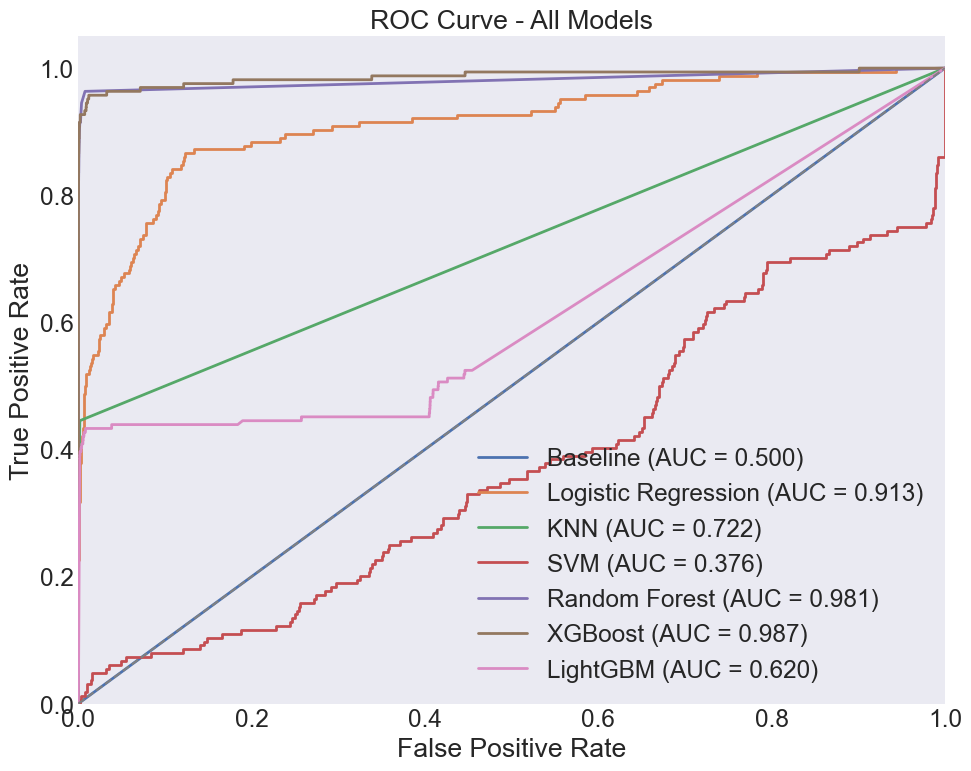

In [275]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

models = {
    "Baseline": dummy,
    "Logistic Regression": lg,
    "KNN": knn,
    "SVM": svm,
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lightgbm,
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_cs)[:, 1]
    else:
        y_scores = model.decision_function(X_test_cs)  # dành cho SVM

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()